[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Tue Oct  1 13:03:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [2]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 41.5/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [3]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

  0% 15.2k/5.35M [00:00<00:00, 32.3MB/s]
######################################################################## 100.0%
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 104k/104k [00:00<00:00, 107MB/s]
image 1/1 /content/dog.jpeg: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 58.0ms
Speed: 10.2ms preprocess, 58.0ms inference, 448.6ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

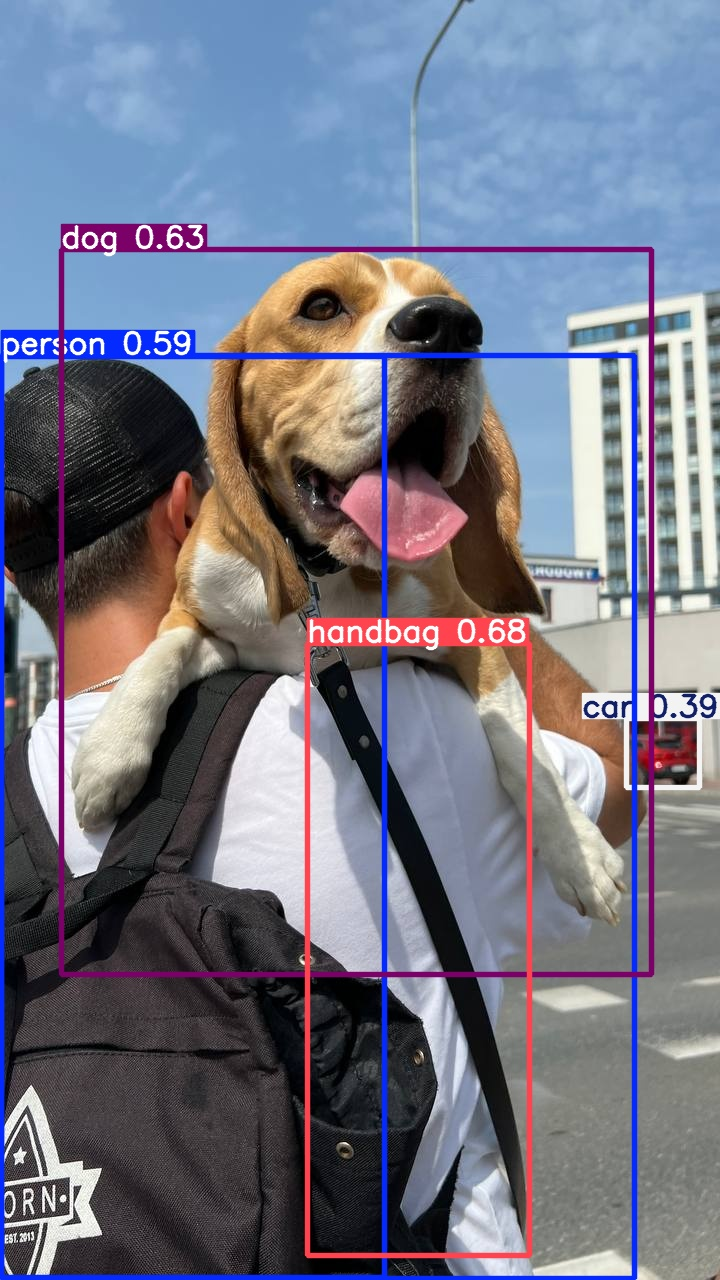

In [5]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/dog.jpg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [6]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 59.0ms
Speed: 6.4ms preprocess, 59.0ms inference, 148.7ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [7]:
result.boxes.xyxy

tensor([[3.0704e+02, 6.4338e+02, 5.2918e+02, 1.2559e+03],
        [6.1378e+01, 2.4994e+02, 6.5166e+02, 9.7417e+02],
        [1.7878e+00, 3.5550e+02, 6.3408e+02, 1.2788e+03],
        [1.1996e+00, 3.5620e+02, 3.8468e+02, 1.2776e+03],
        [6.2616e+02, 7.1818e+02, 6.9975e+02, 7.8754e+02]], device='cuda:0')

In [8]:
result.boxes.conf

tensor([0.6829, 0.6285, 0.5945, 0.3930, 0.3869], device='cuda:0')

In [9]:
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [10]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

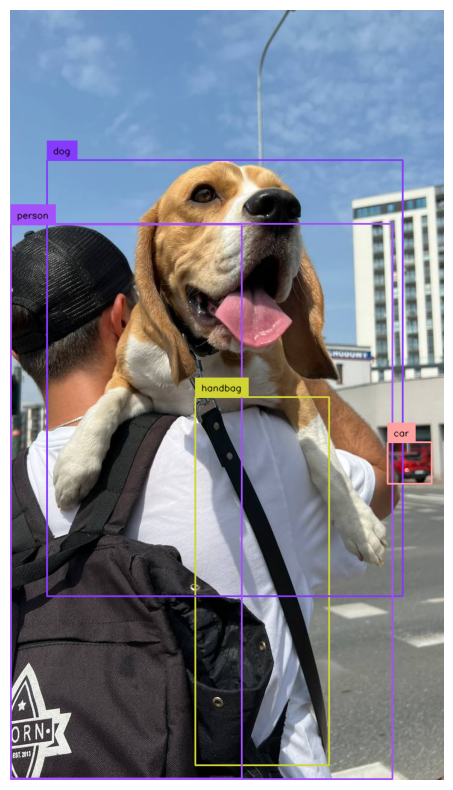

In [11]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("liangdianzhong")
project = workspace.project("-qvdww")
version = project.version(3)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 两点钟模型-3 in yolov11:: 100%|██████████| 2612/2612 [00:00<00:00, 5820.46it/s]


## Custom Training

In [12]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="XK9aIQK76Z3lqYzPJkmU")
project = rf.workspace("roadblocks").project("yoloroad")
version = project.version(3)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to yoloroad-3 in yolov11:: 100%|██████████| 716/716 [00:00<00:00, 1782.67it/s]


In [21]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11n.pt data={dataset.location}/data.yaml epochs=100 imgsz=640 plots=True

/content
New https://pypi.org/project/ultralytics/8.3.138 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/yoloroad-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=No

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [14]:
!ls {HOME}/runs/detect/train/

args.yaml					    results.png
confusion_matrix_normalized.png			    train_batch0.jpg
confusion_matrix.png				    train_batch1.jpg
events.out.tfevents.1747562029.b049cbb2a14f.1715.0  train_batch2.jpg
F1_curve.png					    val_batch0_labels.jpg
labels_correlogram.jpg				    val_batch0_pred.jpg
labels.jpg					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

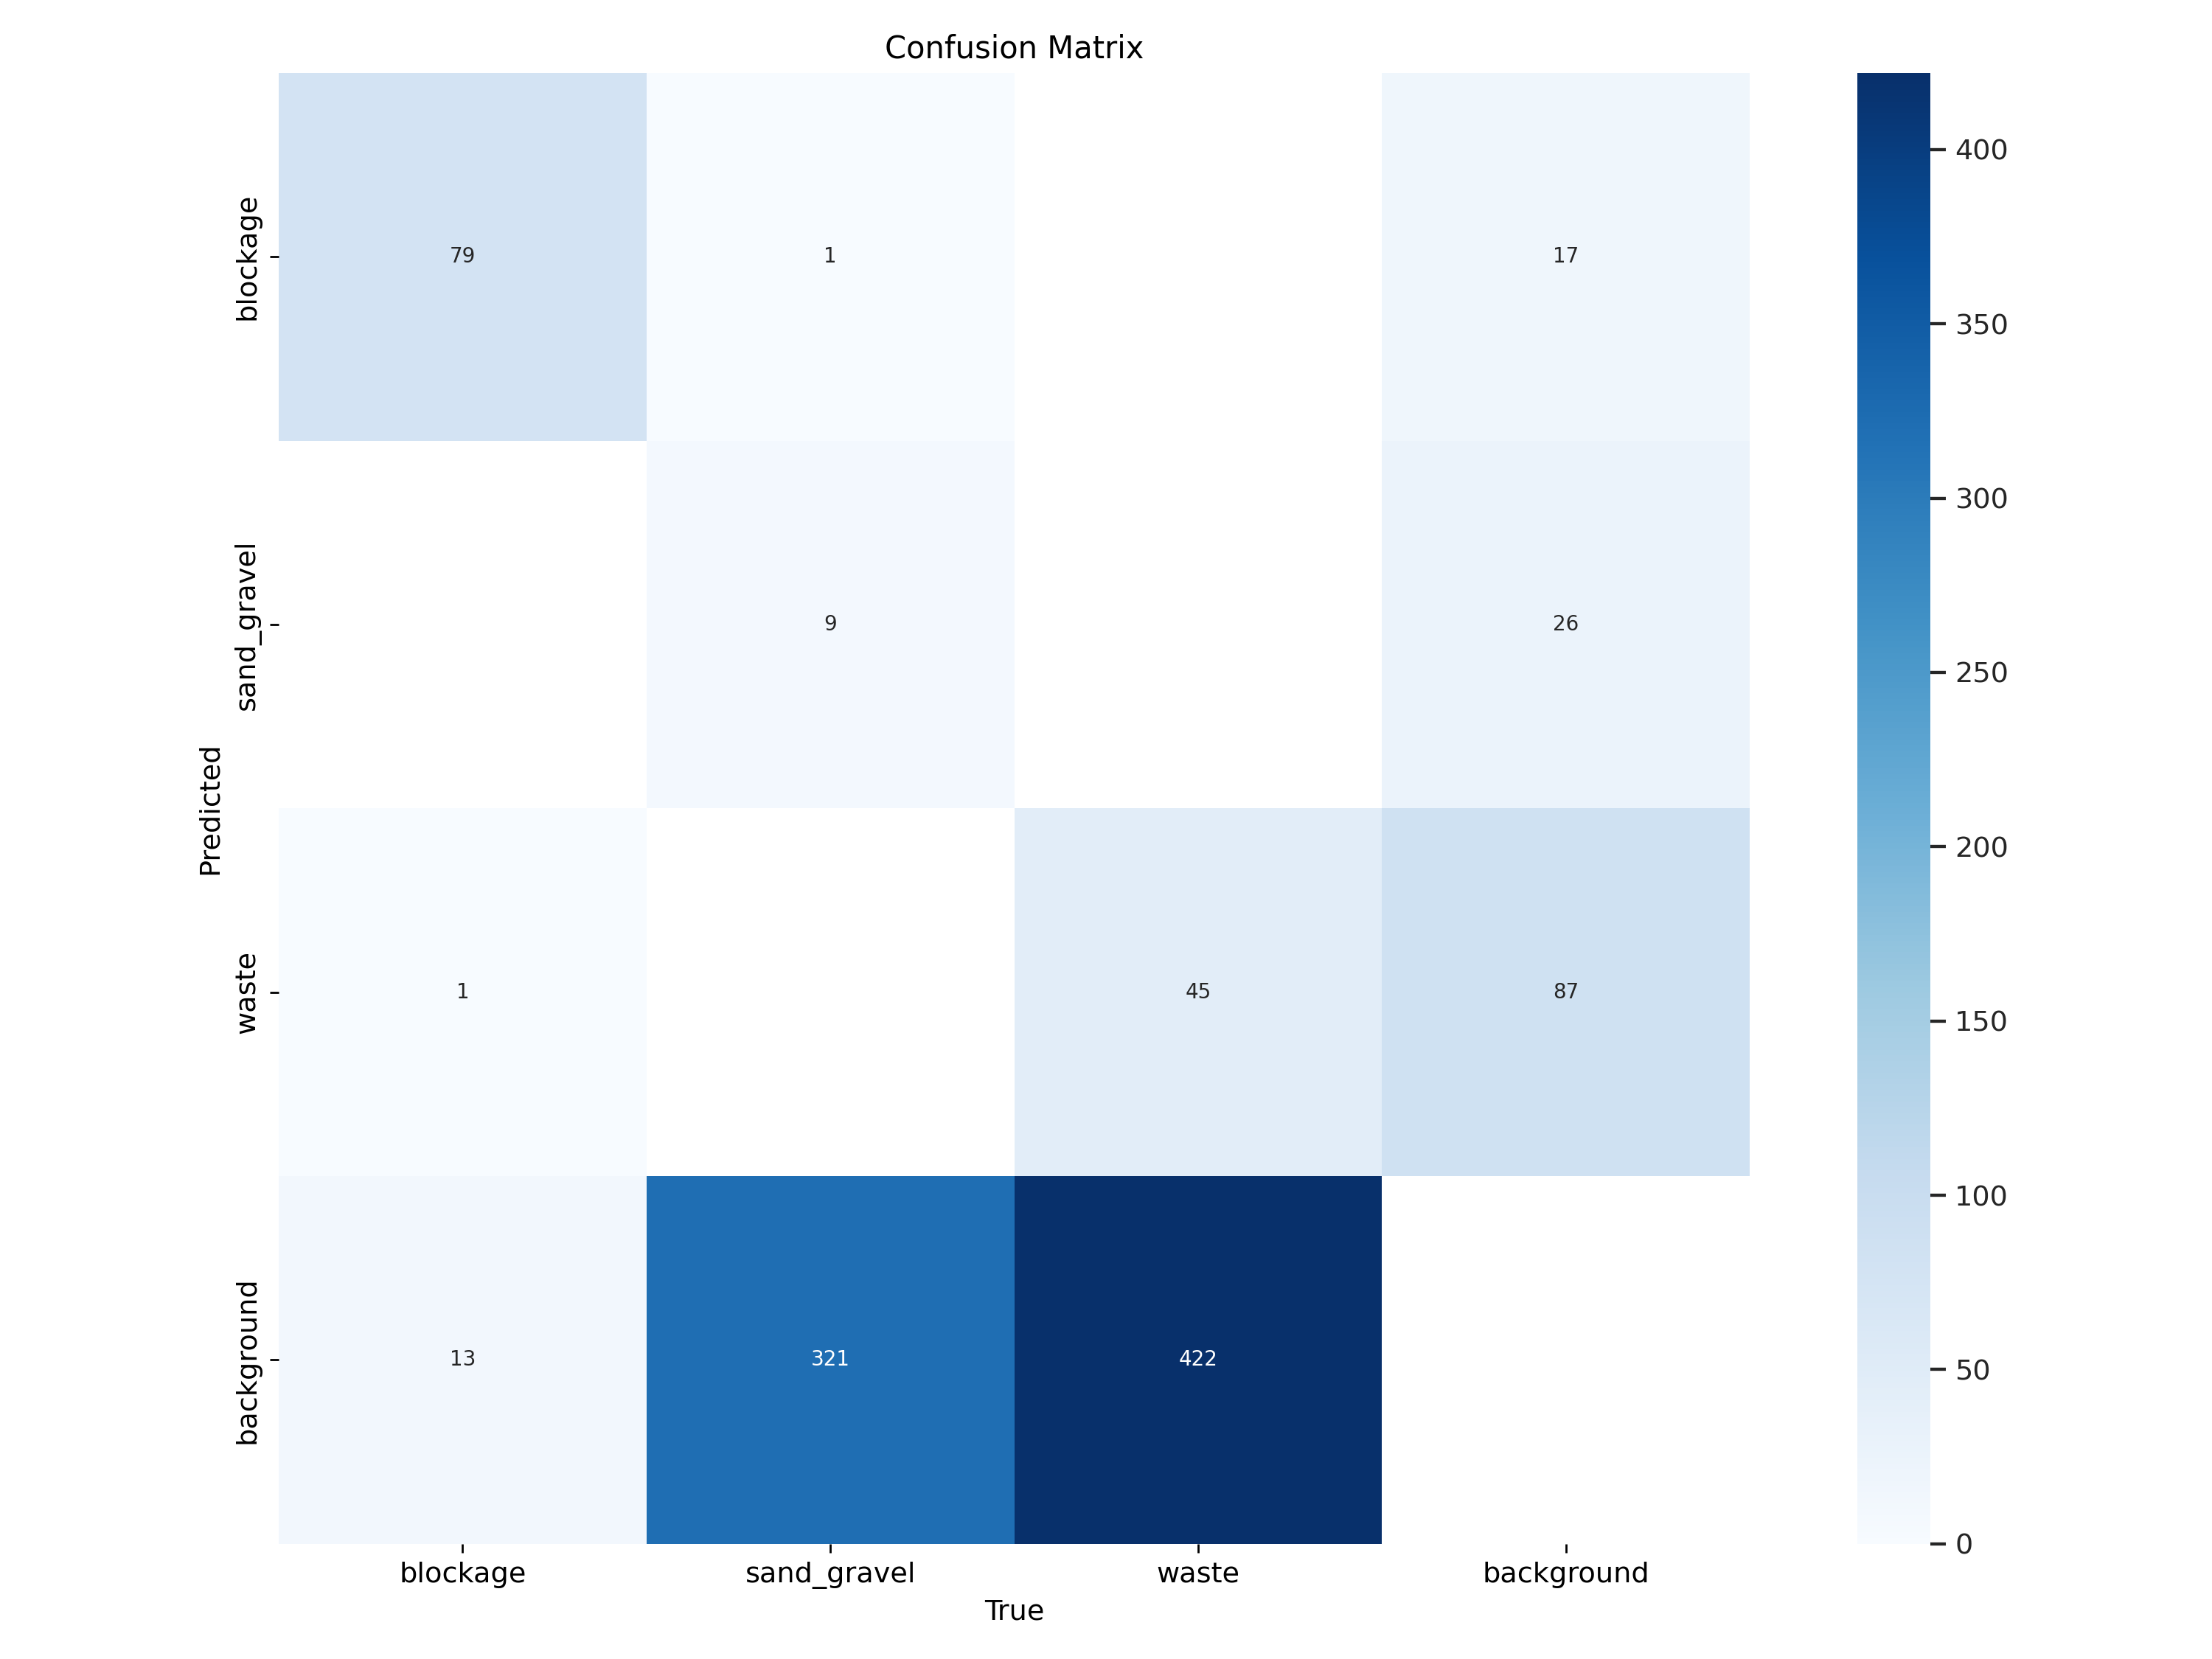

In [22]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=600)

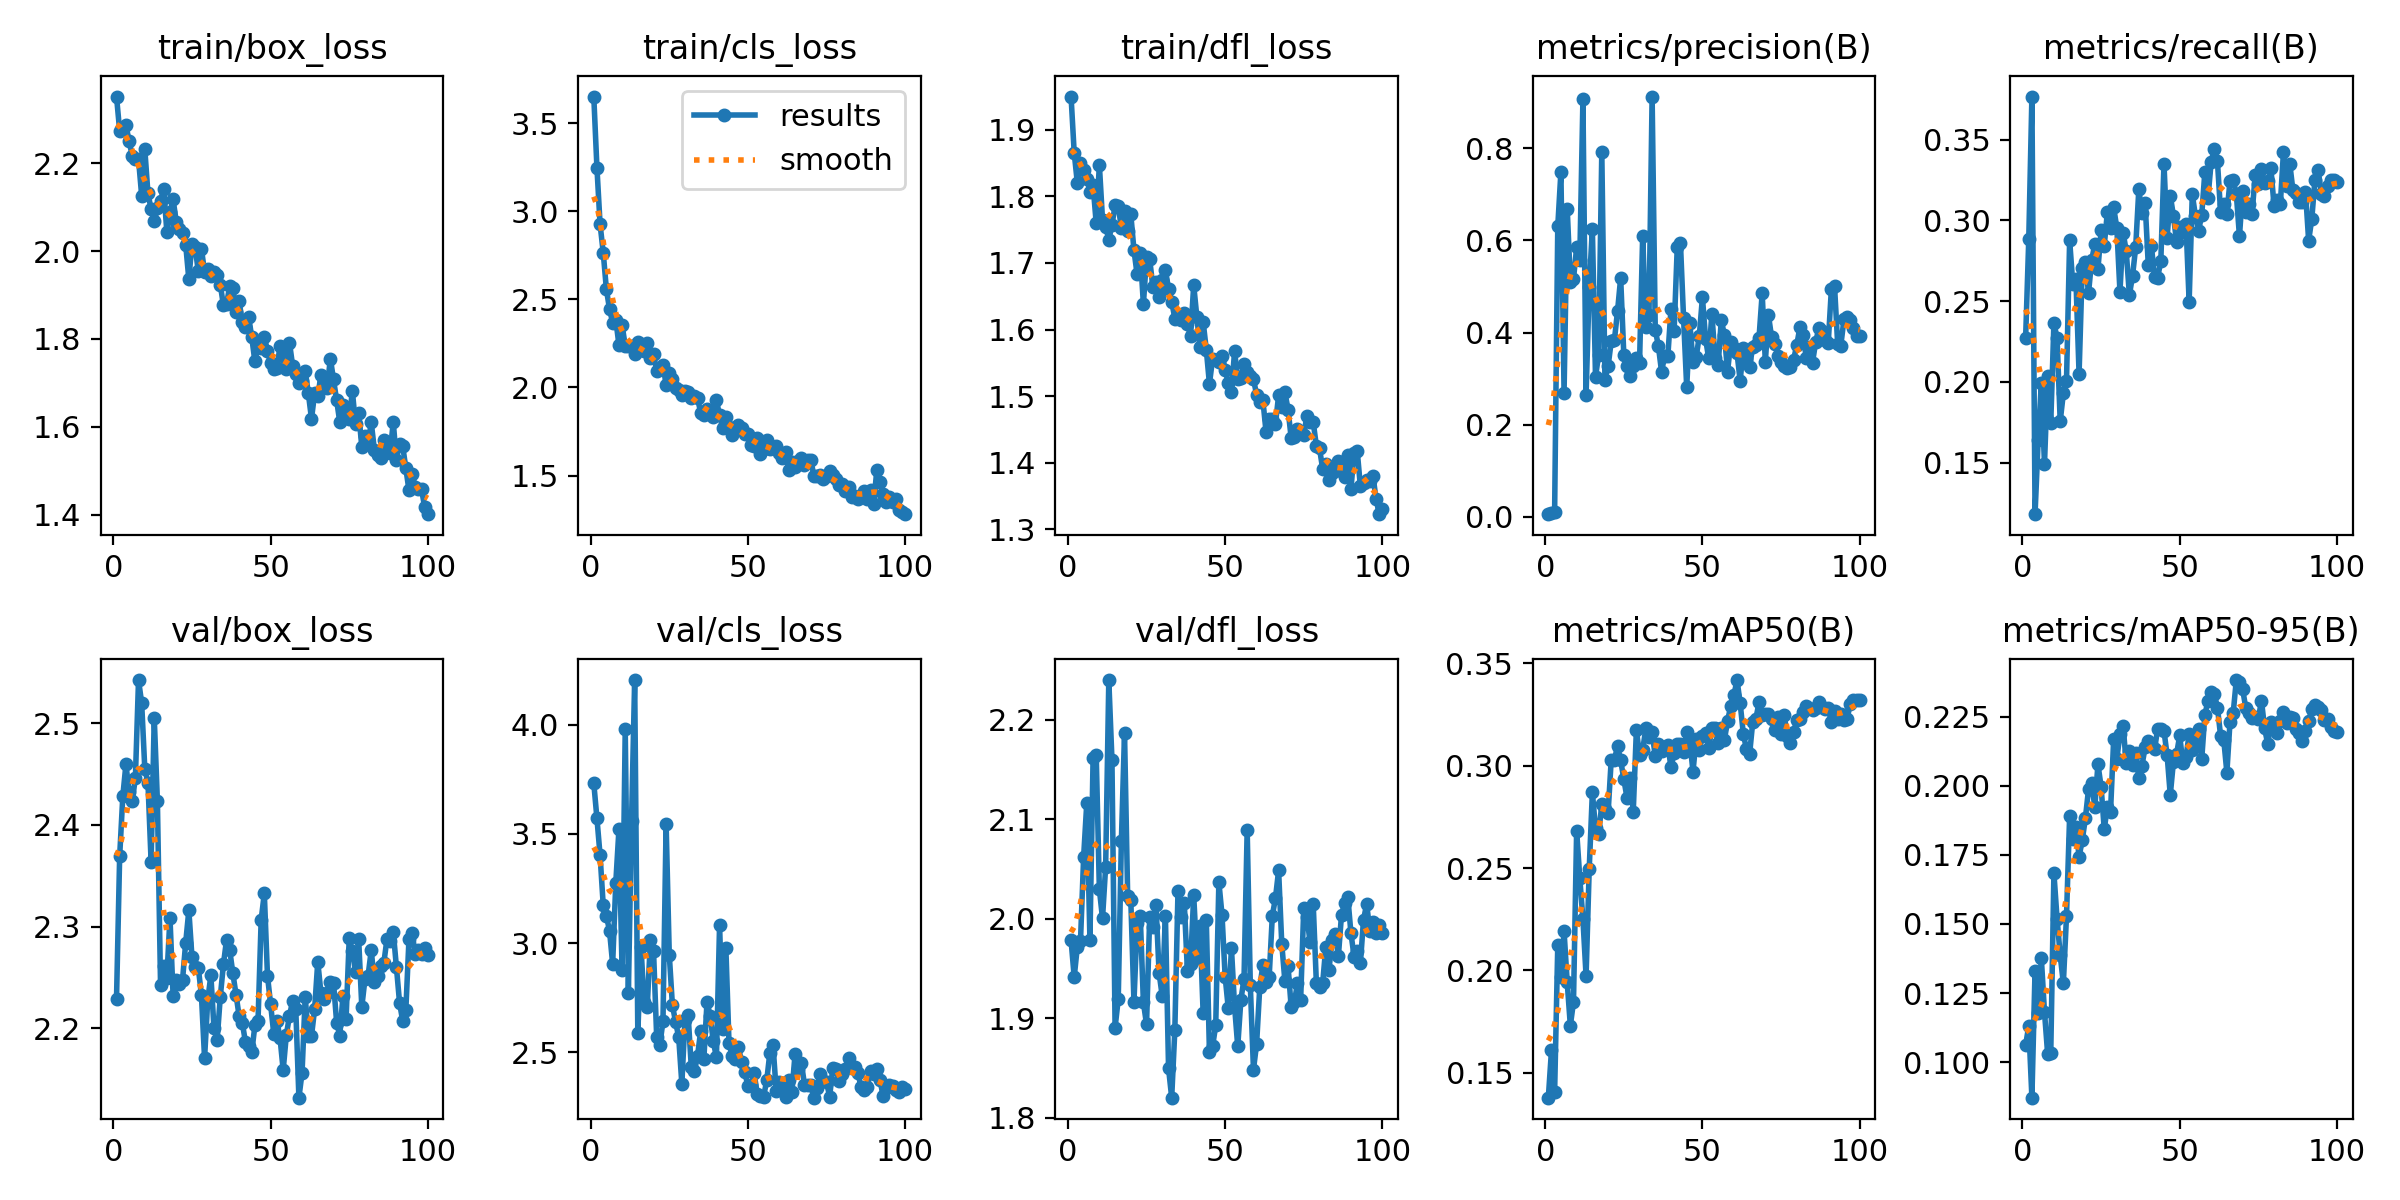

In [23]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

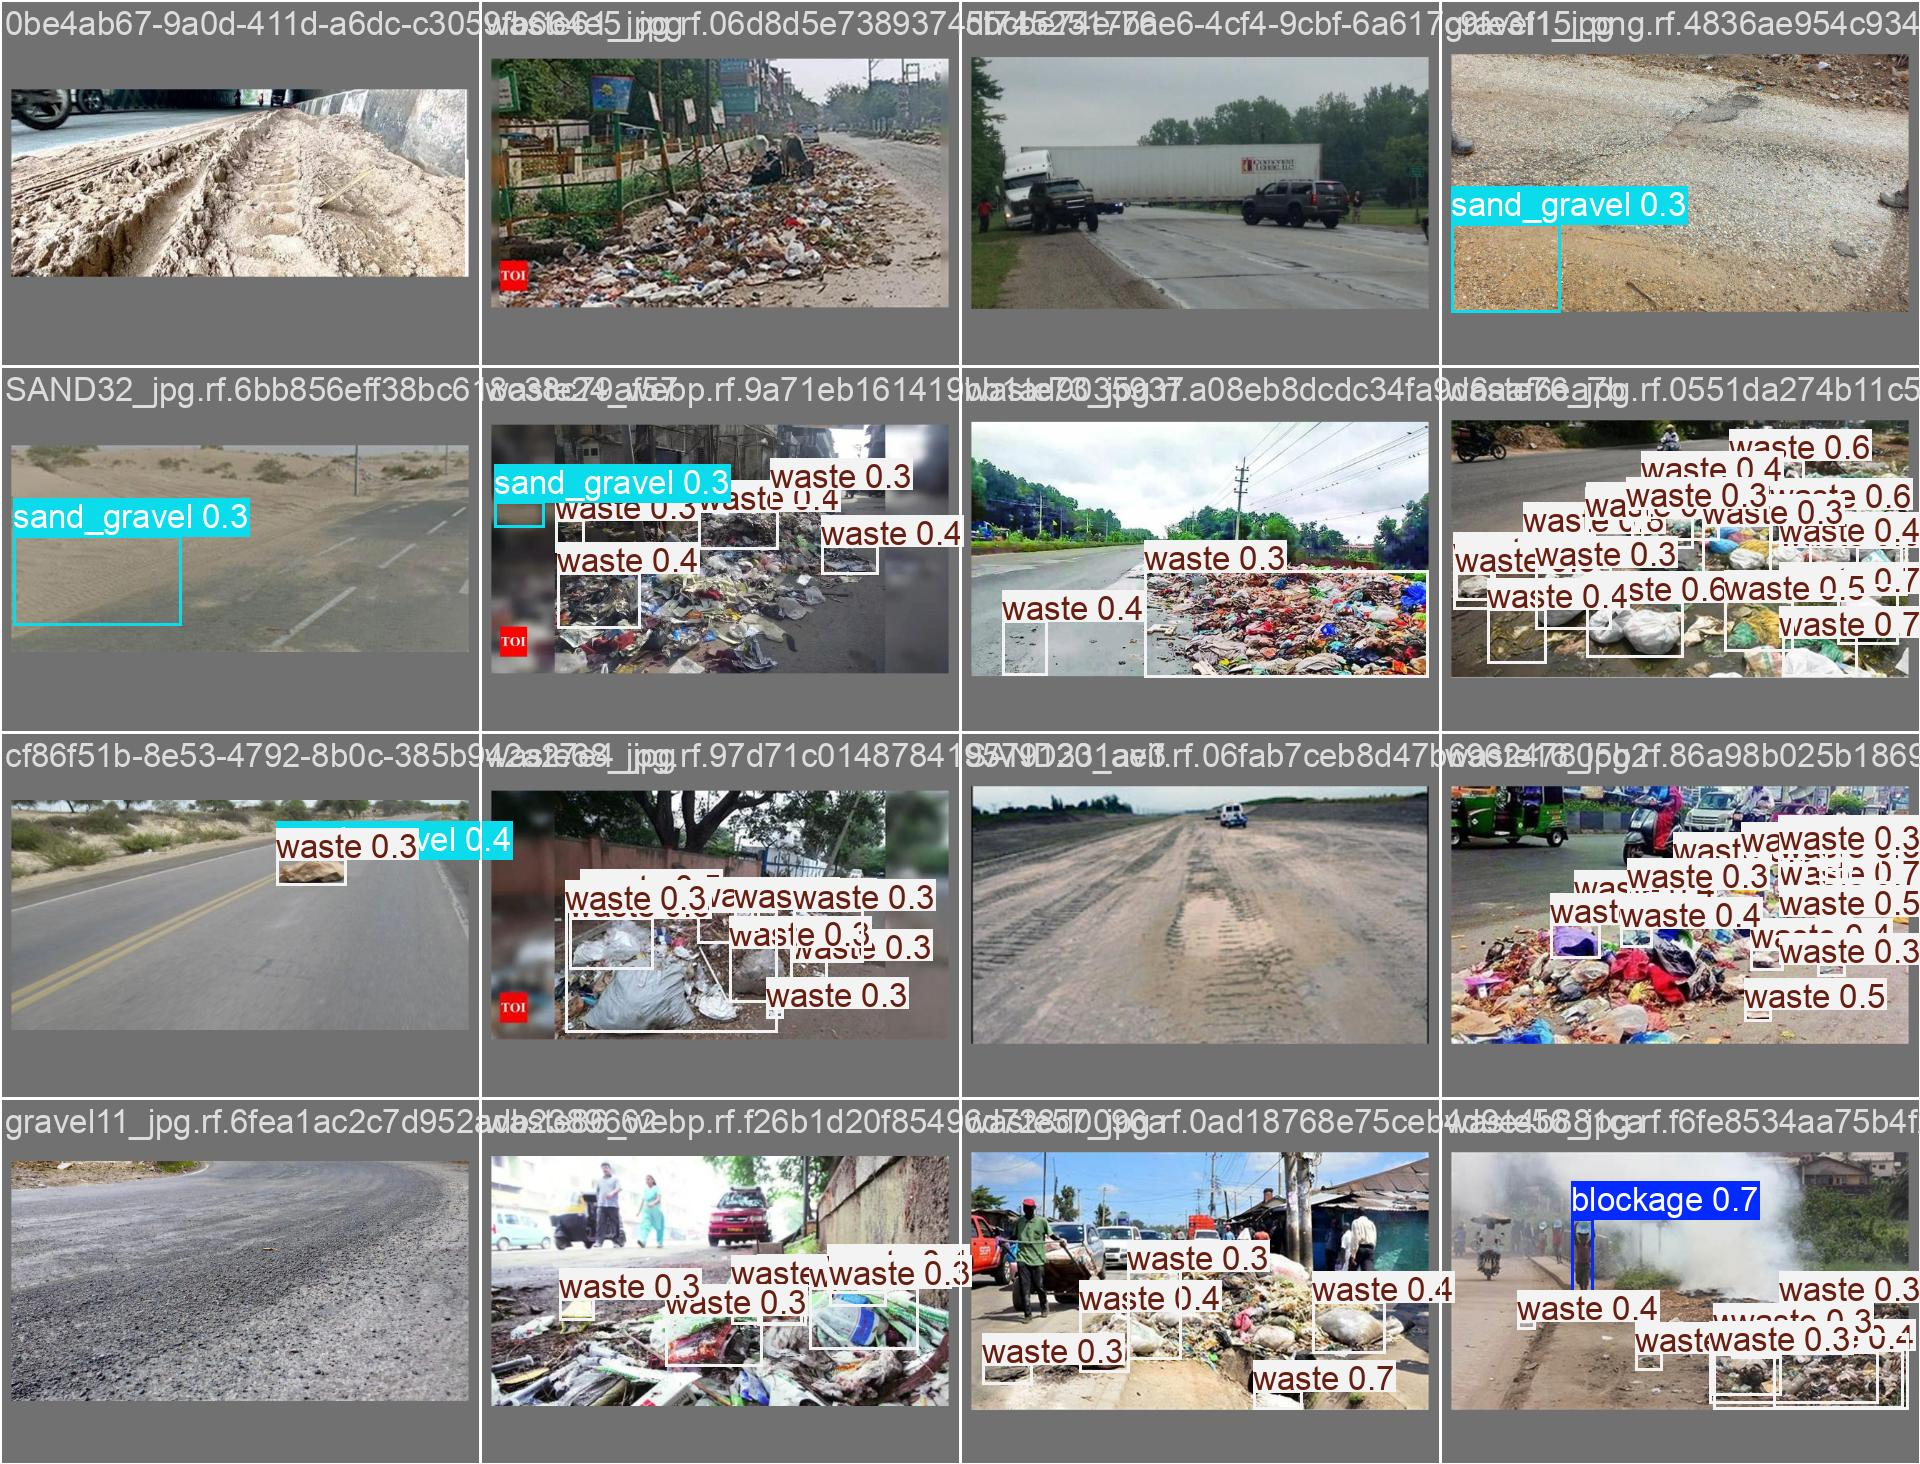

In [25]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [26]:
!yolo task=detect mode=val model={HOME}/runs/detect/train2/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /content/yoloroad-3/valid/labels.cache... 69 images, 2 backgrounds, 0 corrupt: 100% 69/69 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 5, len(boxes) = 891. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:02<00:00,  2.11it/s]
                   all         69        891      0.387      0.315      0.332      0.238
              blockage         29         93       0.81      0.839      0.874       0.67
           sand_gravel         29        331     0.0658     0.0242     0.0228    0.00705
                 waste         21       

## Inference with custom model

In [27]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train2/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

image 1/36 /content/yoloroad-3/test/images/BL13_jpg.rf.71dcb01171dcaef8a82f0a63935700dc.jpg: 448x640 1 blockage, 56.2ms
image 2/36 /content/yoloroad-3/test/images/BL17_jpg.rf.362735eb929288be180156cd5ff5617a.jpg: 480x640 (no detections), 57.5ms
image 3/36 /content/yoloroad-3/test/images/BL18_webp.rf.5909371b8c0e830178733a41f8d89e57.jpg: 480x640 1 blockage, 10.5ms
image 4/36 /content/yoloroad-3/test/images/BL23_jpg.rf.3f76aa03e06b6db40e93e0a105847db4.jpg: 448x640 3 blockages, 10.2ms
image 5/36 /content/yoloroad-3/test/images/BL24_jpg.rf.f90f670e4c46c285c7f5effc1bac913d.jpg: 352x640 2 blockages, 54.9ms
image 6/36 /content/yoloroad-3/test/images/BL5_webp.rf.5d7f3c2802847145291f37c4813009bc.jpg: 480x640 1 waste, 10.0ms
image 7/36 /content/yoloroad-3/test/images/IMG20250316164428_jpg.rf.6c716a23a838ed3490f7760e7ed3

**NOTE:** Let's take a look at few results.

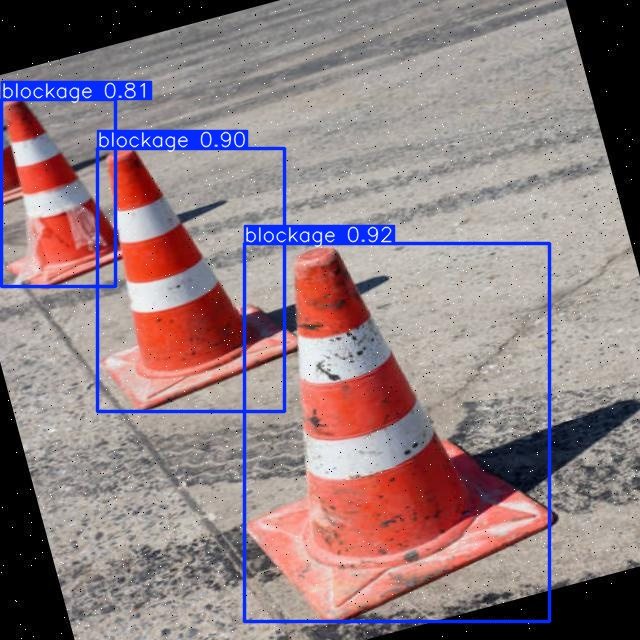

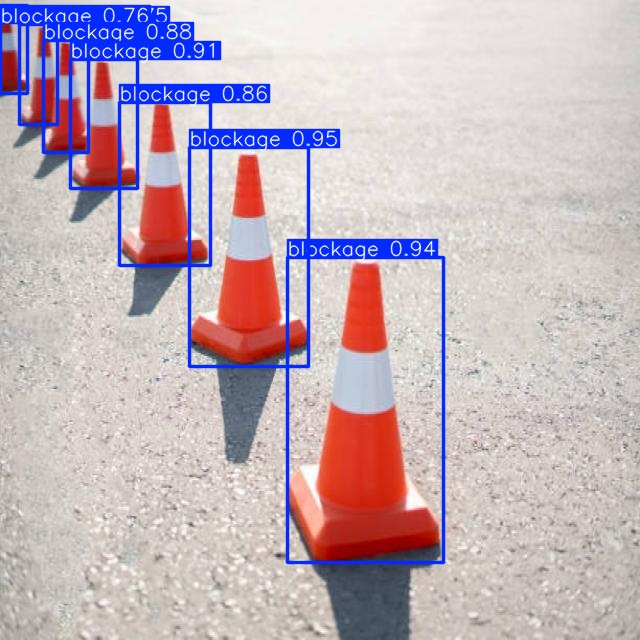

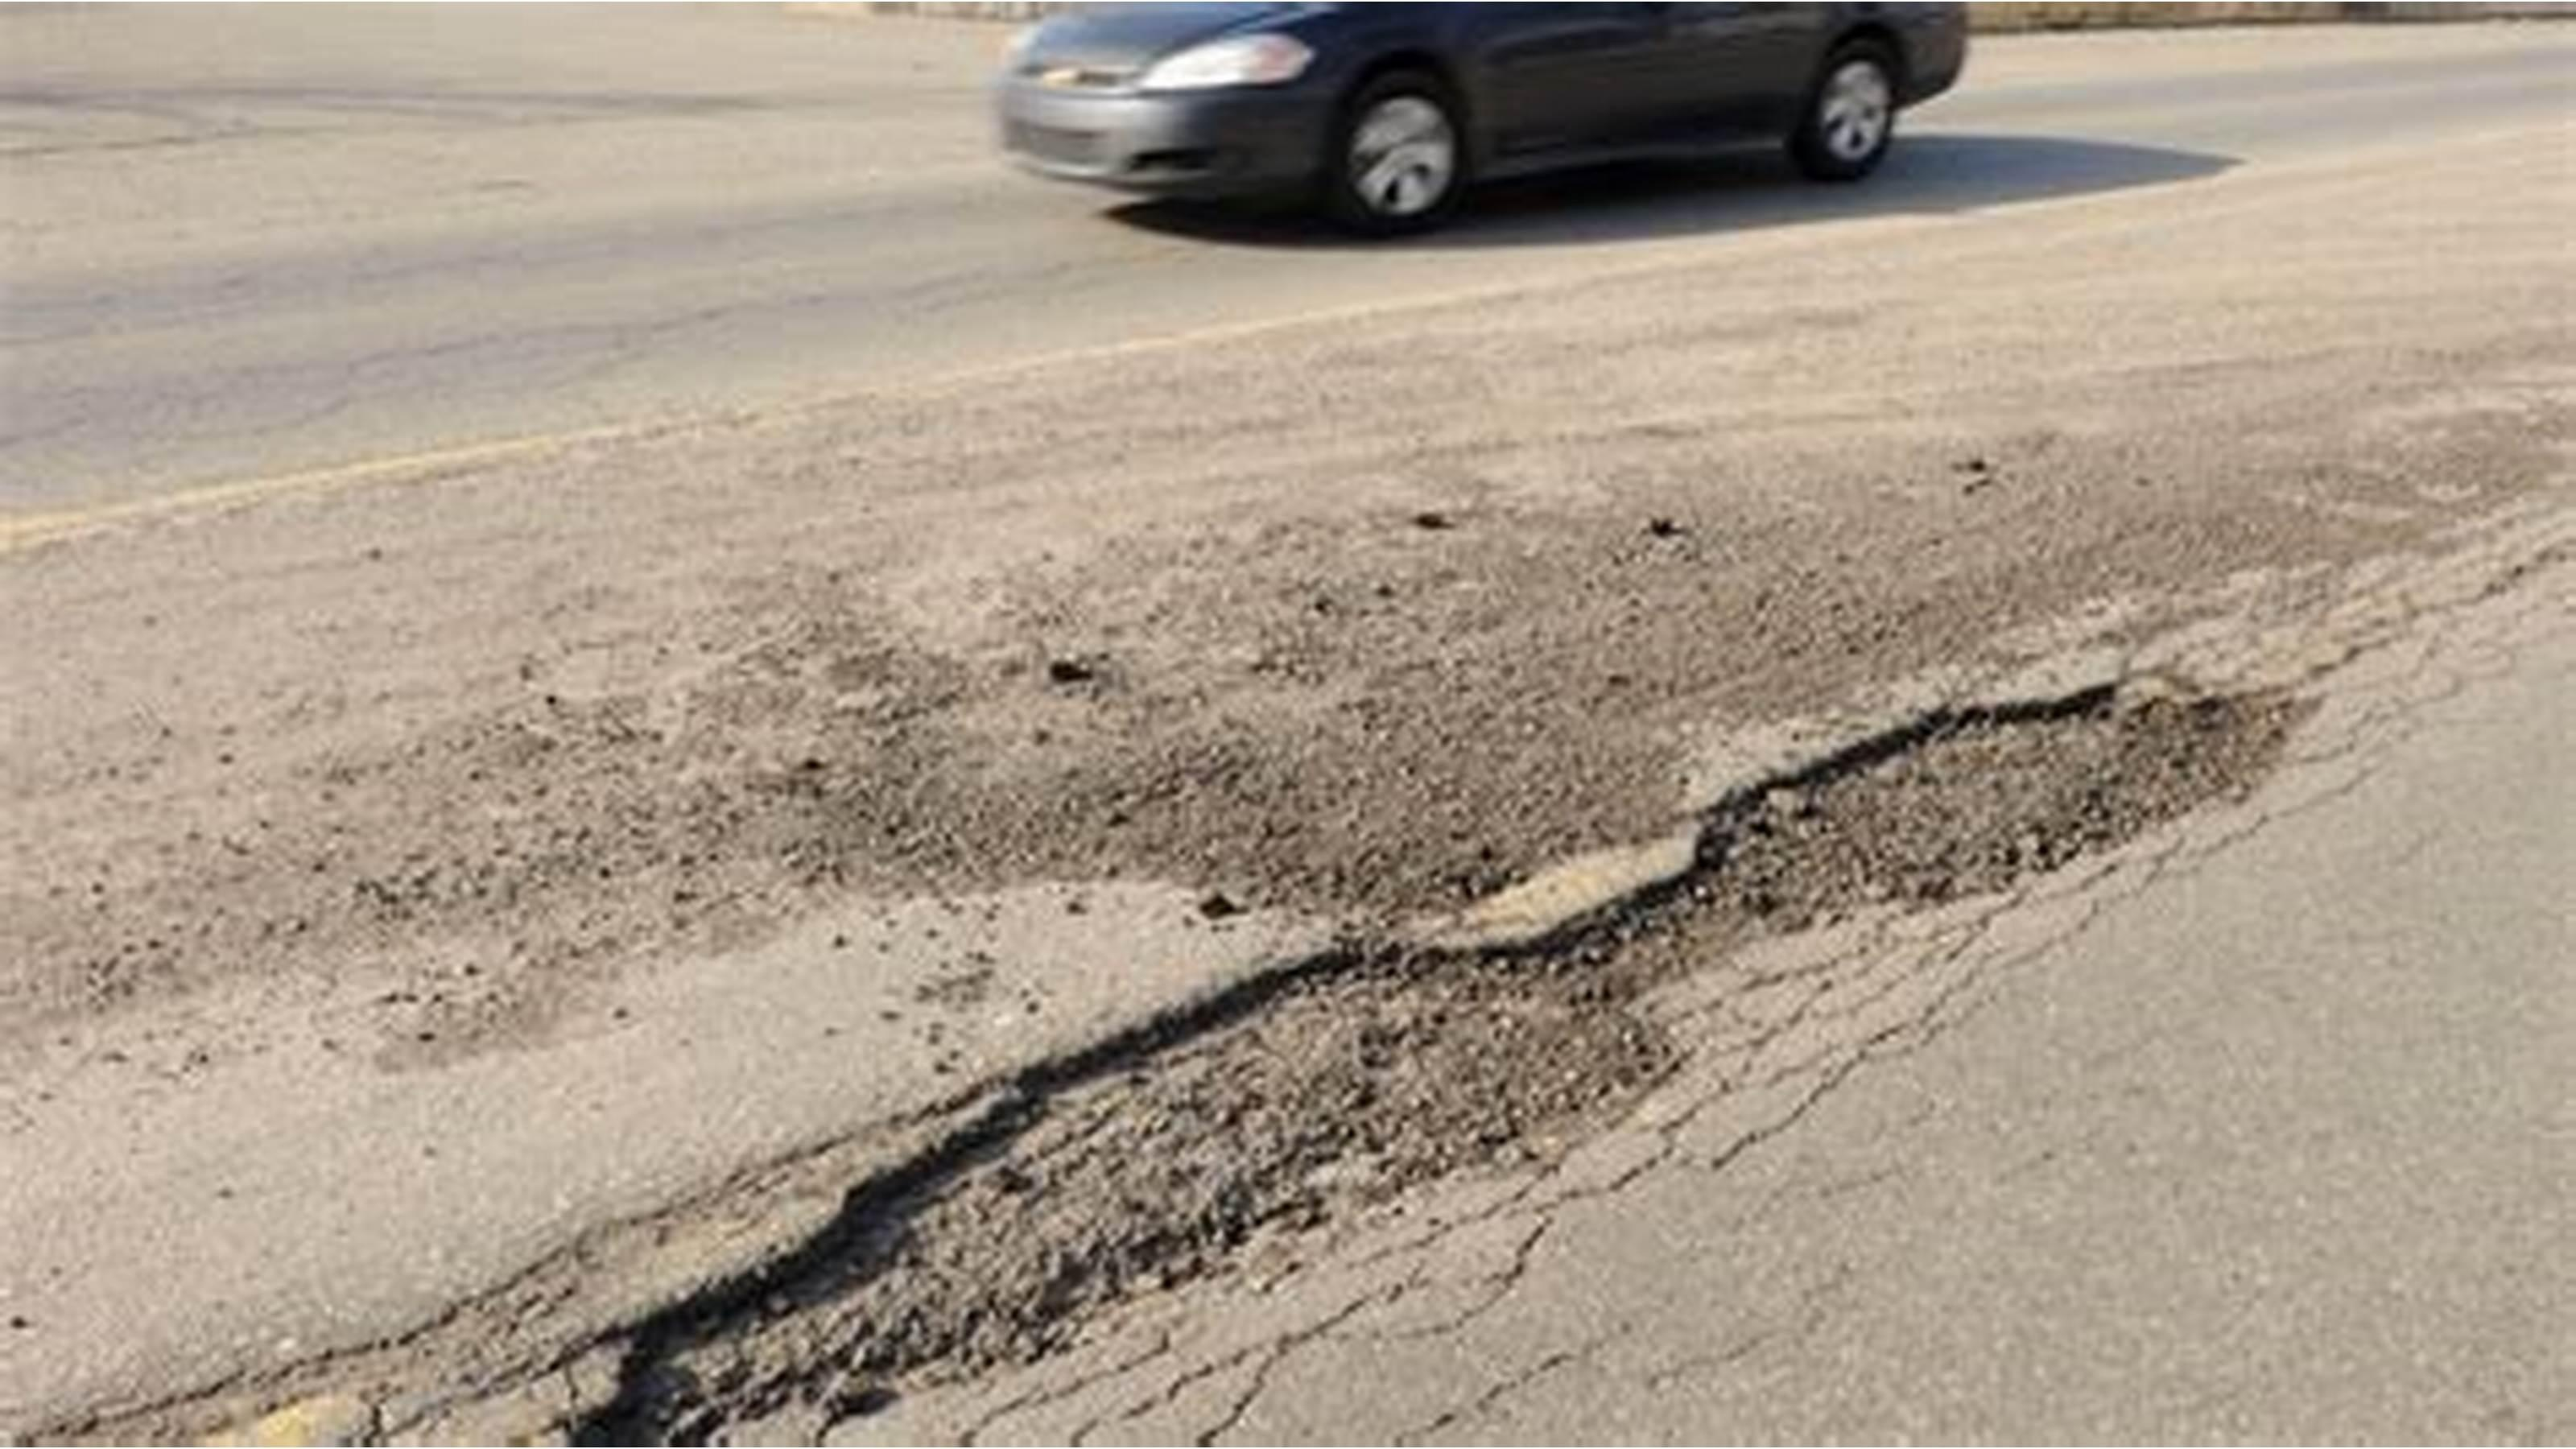

In [28]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict2*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.